In [1]:
%matplotlib inline
from __future__ import division
%load_ext autoreload
%autoreload
import numpy as np
from KBO import *
from linktools import *
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
import networkx as nx

In [2]:
truth_in = 'fakes_40_50_AU_S1.csv'
fakes_det_in = 'noise_catalogs_40_50AU/cat_noise_4090.csv'   # typical catalog with noise
do_noise = True     # include noise points in analysis
astrometric_err = 0.2   # estimated astrometric error in arcseconds
fakes_truth = pd.read_csv(truth_in) 
fakes_det = pd.read_csv(fakes_det_in)

In [3]:
# Create the input catalog
def ingest_catalog(fake_det_in):
    fake_cat = Catalog(rows=fakes_det_in,fakeid=int,date=float,expnum=int,exptime=float, 
                       ra=float,dec=float,band=str,ccd=int,nite=int,objid=int)
    fake_cat.refactor('date', lambda date: ephem.date(date))
    fake_cat.refactor('ra',  lambda ra: hours(ra))
    fake_cat.refactor('dec', lambda dec: degrees(dec))
    return fake_cat
fake_cat = ingest_catalog(fakes_det_in)

In [4]:
def denoise(catalog):
    return Catalog(p for p in catalog._points if p.fakeid>0)

In [5]:
def make_kdtree(catalog):
    '''
    Makes a KDtree from the ra, dec points in catalog.
    '''
    x = np.array([[point.ra for point in catalog], 
                  [point.dec for point in catalog]]).transpose()
    return KDTree(x)

In [55]:
class TNOfinder(object):
    def __init__(self, objcat, band = None, exclude_objids=None, date_start=None, look_ahead_nights=30,
                nominal_distance=60):

# objcat is a Catalog (for now) which must contain at least the following columns:
#     date (as a DateTime object)
#     nite
#     ra, dec in radians or ephem.Angle objects
#     band
#     expnum
#     exptime (in seconds)
#     objid (a unique identifier, such as snobjid)
#     mag
#     ccd
        self.objects = objcat
        if band is not None: self.objects = Catalog(obj for obj in self.objects if obj.band == band)
        if exclude_objids is not None: self.objects = Catalog(obj for obj in self.objects if obj.objid not in exclude_objids)
#
        if date_start is not None: self.objects = Catalog(obj for obj in self.objects if obj.date>=date_start)
        self.objects.add_constant('obscode', 807)
        self.objects.add_constant('err', astrometric_err)
        self.objects.orderby('date')
        self.band = band
        self.look_ahead_nights = look_ahead_nights   # how many visits to look ahead for linking
        self.nominal_distance = nominal_distance  # AU
        self.vmax = 150 # arcsec/day
        self.nites = sorted(set(point.nite for point in self.objects))
        self.para = exposure_parallax()        # get dlon, dlat, vlon, vlat for each exposure
        self.good_triplets = []
        self.graph = nx.Graph()
        self.candidates = []
        
    
    def nites_between(self, nite1, nite2):
        '''
        Returns the time in days between two nites, where nite2>nite1.
        '''
        return ephem.date(pretty_nite(nite2))-ephem.date(pretty_nite(nite1))
        
    def cosine_cut(self, displacement_arcsec):
        '''
        The requirement on directional alignment between two points and that expected from earth reflex motion.
        It's more generous for lower values of the displacement (in arcseconds).
        '''
        if displacement_arcsec<400:
            return 0.7
        elif 400<displacement_arcsec<=800:
            return 0.7 + (0.95-0.7)/(800-400)*(displacement_arcsec-400)
        else:
            return 0.95
    
    def tno_like(self, point1, point2, lon1, lat1, dlon, dlat):
        '''
        returns True if point1 and point2 are in a TNO-like relationship to each other, i.e. displacement
        magnitude and direction consistent with earth reflex motion. 
        point1 = point in earlier visit
        point2 = point in subsequent visit that we are trying to link to point1.
        lon1, lat1 = ecliptic coords of point1
        dlon, dlat = expected change in direction from one visit to next: dlon = nextvisit.dlon - thisvisit.dlon, etc.
        '''
        lon2, lat2 = Ecliptic(Equatorial(point2.ra, point2.dec)).get()
        displacement = ephem.separation((lon2, lat2), (lon1, lat1))
        norm = np.sqrt(np.cos(lat1)**2*dlon**2 + dlat**2)
        dot = np.cos(lat1)**2*(lon2 - lon1)*dlon + (lat2 - lat1)*dlat
        if point2.date != point1.date:
            velocity = displacement/(point2.date - point1.date)
        else: 
            velocity=9999
        cosine = dot/(norm*displacement)
        displacement_asec = displacement*180/np.pi*3600
        return True if velocity<self.vmax and cosine>self.cosine_cut(displacement_asec) else False
       
    def link_obj(self, point):
        nites = self.nites
        thisnite = point.nite
        look_ahead_nites = sorted([n for n in nites if 0<self.nites_between(thisnite,n)<self.look_ahead_nights])
        lon, lat = Ecliptic(Equatorial(point.ra, point.dec)).get()
        this_dlon, this_dlat = self.para[point.expnum]['dlon'], self.para[point.expnum]['dlat']
        next_obj = []
        for next_nite in look_ahead_nites:
            deltaT = self.nites_between(thisnite,next_nite)
            next_dlon, next_dlat, next_vlon, next_vlat = parallax(point.ra, point.dec, point.date+deltaT)
            dlon, dlat = next_dlon-this_dlon, next_dlat-this_dlat
            search_center = Equatorial(Ecliptic(lon+dlon/self.nominal_distance, lat+dlat/self.nominal_distance))
            deltaR = np.sqrt(dlon**2*np.cos(lat)**2 + dlat**2)/self.nominal_distance
#            print ephem.separation((search_center.ra, search_center.dec), (point.ra, point.dec))*3600*180/np.pi/deltaT
            sep_max = self.vmax*np.pi/(180*3600)*(deltaT)/2
            current_objects = [obj for obj in self.objects if obj.nite == next_nite \
                               and (self.band is None or obj.band == self.band) \
                                and ephem.separation((search_center.ra, search_center.dec), (obj.ra, obj.dec))<deltaR]
            # now the real work: for each object, test to see
            # if it's consistent with being the next point in
            # a KBO trajectory, i.e. consistent in direction and displacement with earth parallax.
            for point2 in current_objects:
                next_dlon, next_dlat = self.para[point2.expnum]['dlon'], self.para[point2.expnum]['dlat']
                dlon, dlat = next_dlon-this_dlon, next_dlat-this_dlat
                if self.tno_like(point, point2, lon, lat, dlon, dlat): next_obj.append(point2)
        return next_obj
    
    def find_triplets(self):
        cat1 = self.objects
        current_nite = 0
        good_triplets = []
        for obj1 in cat1:
            if obj1.nite>current_nite:
                self.report_state(current_nite, good_triplets)
                print 'Linking points from nite: ', obj1.nite
                current_nite = obj1.nite
            next_points = self.link_obj(obj1)
            for obj2 in next_points:
#                print '.',
                next_next_points = self.link_obj(obj2)
                for obj3 in next_next_points:
#                    print '-',
                    triple=Catalog([obj1, obj2, obj3])
                    orbit = Orbit(triple)
                    if orbit.chisq<2 and orbit.ndof==1 and orbit.elements['a']>20:    # good triplet
                        good_triplets.append(triple)
        self.good_triplets = good_triplets
        self.candidates = self.tnocands(good_triplets)
        return good_triplets

    def make_graph(self, triplets):
        G = nx.Graph()
        for triplet in triplets:
            observations = sorted([obs.objid for obs in triplet])
            G.add_nodes_from(observations)
            G.add_edge(observations[0], observations[1])
            G.add_edge(observations[1], observations[2])
        return G

    def subgraphs(self, graph):
        return [s for s in nx.connected_component_subgraphs(graph)]

    def connected_observations(self, subgraph):
        objids = [node for node in nx.nodes_iter(subgraph)]
        points = [p for p in self.objects if p.objid in objids]
        cat = Catalog(points)
        cat.add_constant('obscode', 807)
        cat.add_constant('err', astrometric_err)
        return cat
    
    def tnocands(self, triplets):
        subs = self.subgraphs(self.make_graph(triplets))
        observations = [self.connected_observations(sub) for sub in subs]
        orbits = [Orbit(obs) for obs in observations]
        return zip(orbits, observations)
    
    def report_state(self, nite, triplets):
        cands = self.tnocands(triplets)
        print 'Status after nite ', nite
        print 'Good triplets found: ', len(cands)
        for cand in cands:
            orbit, observations = cand[0], cand[1]
            print 'Chi^2, ndof: ', orbit.chisq, orbit.ndof
            print 'Elements: ', orbit.elements
            print 'Element errors:', orbit.elements_errs
            print 'Observations: '
            print observations.writes()
            print
        print '--------------------------------------------------------------------------------------------'
            

In [26]:
def process_catalog(catalog, look_ahead_nights=14, nominal_distance=60):
    linker = TNOfinder(catalog, look_ahead_nights=look_ahead_nights, nominal_distance=nominal_distance)
    linker.find_triplets()
    return linker

#good_triplets = process_catalog(fake_cat)
#print 'Good triplets found: ', len(good_triplets)

In [9]:
def subgraphs(triplets):
    G = nx.Graph()
    for triplet in triplets:
        observations = sorted([obs.objid for obs in triplet])
        G.add_nodes_from(observations)
        G.add_edge(observations[0], observations[1])
        G.add_edge(observations[1], observations[2])
    return [s for s in nx.connected_component_subgraphs(G)]

def connected_observations(catalog, subgraph):
    objids = [node for node in nx.nodes_iter(subgraph)]
    points = [p for p in catalog if p.objid in objids]
    cat = Catalog(points)
    cat.add_constant('obscode', 807)
    cat.add_constant('err', astrometric_err)
    return cat

In [10]:
def isSignal(cat):
    return np.all([obs.fakeid>0 for obs in cat])

In [10]:
from os import listdir
from os.path import isfile, join
path = 'noise_catalogs_40_50AU'
catfiles = [f for f in listdir(path) if isfile(join(path,f))]

In [11]:
Ntot = 0
Nfound = 0
for cat_in in catfiles:
    fake_cat = ingest_catalog(join(path,cat_in))
    Ntot +=1
    print 'Processing catalog ', cat_in
    good_triplets = process_catalog(denoise(fake_cat))
#    print 'Good triplets found: ', len(good_triplets)
    subs = subgraphs(good_triplets)
#    print 'Connected subgraphs found: ', len(subs)
    orbits = []
    big_subs=[]
    for sub in subs:
        if len(sub)>=3:
            big_subs.append(sub)
            observations = connected_observations(fake_cat, sub)
            if isSignal(observations):
#                orbit = Orbit(observations)
#                orbits.append(orbit)
#                print orbit.chisq, orbit.ndof, orbit.elements, orbit.elements_errs
                Nfound +=1
print 'Found ', Nfound, ' of ', Ntot, ' detectable fakes'
        

Processing catalog  cat_noise_1012722.csv
Linking points from nite:  20131024
Linking points from nite:  20131028
Linking points from nite:  20131105
Linking points from nite:  20131109
Linking points from nite:  20131112
Linking points from nite:  20131119
Linking points from nite:  20131128
Linking points from nite:  20131202
Linking points from nite:  20131209
Linking points from nite:  20131218
Linking points from nite:  20131222
Linking points from nite:  20131226
Linking points from nite:  20140102
Linking points from nite:  20140111
Linking points from nite:  20140118
Linking points from nite:  20140125
Linking points from nite:  20140201
Linking points from nite:  20140208
Processing catalog  cat_noise_1021621.csv
Linking points from nite:  20131024
Linking points from nite:  20131028
Linking points from nite:  20131105
Linking points from nite:  20131109
Linking points from nite:  20131112
Linking points from nite:  20131119
Linking points from nite:  20131128
Linking points f

KeyboardInterrupt: 

In [ ]:
r2d = 180/np.pi
cat_clean = denoise(fake_cat)
fig = plt.figure(2, figsize=(12,12))
ax = fig.add_subplot(1,1,1)
for i in range(len(cat_clean._points)-1):
    point = cat_clean._points[i]
    next_point = cat_clean._points[i+1]
    lon, lat = Ecliptic(Equatorial(point.ra, point.dec)).get()
    date = str(ephem.date(point.date)).split()[0][5:]
    lon2, lat2 = Ecliptic(Equatorial(next_point.ra, next_point.dec)).get()
    dlon, dlat = para[next_point.expnum]['dlon']-para[point.expnum]['dlon'], para[next_point.expnum]['dlat']-para[point.expnum]['dlat']
    vlon, vlat = para[point.expnum]['vlon'], para[point.expnum]['vlat']
#    plt.arrow(lon, lat, dlon/40, dlat/40, lw=1, ls='dashed', head_width=0.0005, head_length=0.0005, 
#              fc='b', ec='k', alpha=0.5)
    ax.plot([lon*r2d, (lon+dlon/40)*r2d], [lat*r2d, r2d*(lat+dlat/40)], lw=1, color='b')
    ax.text(lon*r2d-0.04, lat*r2d+0.03, date, fontsize=8, color='k')
    ax.scatter(lon*r2d, lat*r2d, s=20, color='r')
    ax.set_aspect('equal')
    ax.grid()
    r = np.sqrt(dlon**2*np.cos(lat)**2 + dlat**2)/30
    circle = plt.Circle((r2d*(lon+dlon/40), r2d*(lat+dlat/40)), r*r2d , color='b', alpha=0.15)
    fig.gca().add_artist(circle)
    ax.set_xlabel('Ecliptic longitude (deg.)', fontsize=16)
    ax.set_ylabel('Ecliptic latitude (deg.)', fontsize=16)
    ax.set_xlim([39.3, 41.5])
    ax.set_ylim([-16.2, -15.0])
    plt.savefig('linkplot_'+str(i)+'.png')
    plt.savefig('linkplot_'+str(i)+'.pdf')

#orbit = Orbit(observations)
#print orbit.elements, orbit.elements_errs

In [48]:
# Let's take another swing at the Y1 fields. Treat the two fields together this time.
# Read in the catalogs:
import pickle 
#cat_1 = Catalog(pickle.load(open('/Users/gerdes/TNO/kbo_data_Y1REPROC_X3.obj')))
#cat_2 = Catalog(pickle.load(open('/Users/gerdes/TNO/kbo_data_Y1REPROC_X2.obj')))
#cat_all = Catalog(cat_1._points + cat_2._points)
cat_all = Catalog('X3field_Y1reproc.csv',SNOBJID=int,RA=float,DEC=float,EXPTIME=float,EXPNUM=int,NITE=int,BAND=str,
                  DATE_OBS=str,MAG=float,CCDNUM=int,PIXELX=float,PIXELY=float,SEXPSF=float,
                  SEXPSFERR=float,ML_SCORE=float)
cat_all.rename(date='DATE_OBS', ra='RA', dec='DEC', band='BAND', mag='MAG', ccd ='CCDNUM', ml_score='ML_SCORE',
             objid='SNOBJID', expnum = 'EXPNUM', exptime='EXPTIME', sexpsf='SEXPSF', sexpsferr='SEXPSFERR', nite='NITE')
cat_all.refactor('date', toDateTime)
cat_all.refactor('ra', lambda ra: hours(ra * np.pi/180))
cat_all.refactor('dec', lambda dec: degrees(dec * np.pi/180))
def expinfo(expnum):
    try:
        this_exp = [e for e in exposures if e.expnum==expnum][0]
        return dict([('nite',this_exp.nite),('t_eff',this_exp.t_eff), ('fwhm',this_exp.fwhm_asec)])
    except IndexError:
#        print 'expnum ', expnum,': exposure quality info not found, setting t_eff=99'
        return dict([('nite',0),('t_eff',99), ('fwhm',0)])
#cat_all.add_property('nite', lambda pt: expinfo(pt.expnum)['nite'])

for p in cat_all._points[:3]: print p.nite, p.expnum, p.date, p.ra, p.dec, p.exptime, p.band, p.t_eff

20130831 229374 2013/9/1 04:58:45 2:24:38.91 -5:21:06.5 200.0 g None
20130831 229374 2013/9/1 04:58:45 2:24:57.58 -5:16:21.9 200.0 g None
20130831 229374 2013/9/1 04:58:45 2:24:57.58 -5:16:21.9 200.0 g None


In [49]:
# Choose r- and i-band only:
cat_in = Catalog([p for p in cat_all if p.band in ['r','i']])
print len(cat_in._points)

4877


[230151, 232354, 238070, 238099, 244239, 247167, 247175, 253706, 255918, 256177, 262249, 273340, 281593]
13


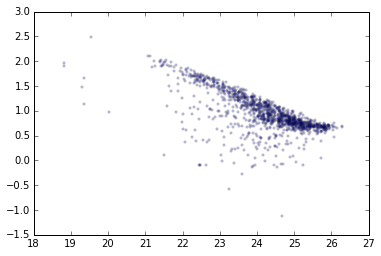

In [50]:
# Don't want to consider exposures taken under poor conditions. Let's plot t_eff and fwhm for this data set 
# and see if there's a clear place to cut.
exp_list = sorted(set([p.expnum for p in cat_in]))
t_eff_list = [e.t_eff for e in exposures if e.expnum in exp_list]
fwhm_list = [e.fwhm_asec for e in exposures if e.expnum in exp_list]
bad_exps = [e.expnum for e in exposures if e.expnum in exp_list and 0<e.t_eff<0.3]
print bad_exps
#plt.scatter(t_eff_list, fwhm_list, color='b',s=5)
flux = np.array([p.sexpsf for p in cat_in if p.band=='r' and p.expnum not in bad_exps])
flux_err = np.array([p.sexpsferr for p in cat_in if p.band=='r' and p.expnum not in bad_exps])
mags = np.array([p.mag for p in cat_in if p.band=='r' and p.expnum not in bad_exps])
snr = np.log10(flux/flux_err)
plt.scatter(mags, snr, s=5, alpha=0.2)
print len(bad_exps)

In [51]:
# Try a simple cut on t_eff:
print len(cat_in._points)
cat_final = Catalog([p for p in cat_in if p.expnum not in bad_exps])
print sorted(set([p.nite for p in cat_final]))
print len(cat_final._points)

4877
[20130901, 20130907, 20130911, 20130928, 20131002, 20131010, 20131014, 20131105, 20131106, 20131111, 20131130, 20131209, 20131219, 20131226, 20131227, 20140103, 20140104, 20140111, 20140125, 20140127, 20140203]
3372


In [52]:
print len(cat_in)
def expnite(expnum):
    this_exp = [e for e in exposures if e.expnum==expnum][0]
    return this_exp.nite
#cat_in.add_property('nite', lambda pt: expnite(pt.expnum))
for p in cat_final._points[:3]: print p.nite, p.expnum, p.date

4877
20130901 229739 2013/9/2 09:05:37
20130901 229739 2013/9/2 09:05:37
20130901 229739 2013/9/2 09:05:37


In [53]:
print len(cat_final._points)

3372


In [54]:
linker = process_catalog(cat_final, look_ahead_nights=30, nominal_distance=60)

Status after nite  0
Good triplets found:  0
--------------------------------------------------------------------------------------------
Linking points from nite:  20130901
Status after nite  20130901
Good triplets found:  2
Chi^2, ndof:  1.26150766967 3
Elements:  {'a': 79.60825369669112, 'lan': 100.60588511824318, 'e': 0.5457580593940117, 'i': 18.264386815566432, 'top': 2442040.2640674147, 'aop': 222.05460473159474}
Element errors: {'a': 36.066783853684647, 'lan': 0.20973925089903547, 'e': 0.28094942520311161, 'i': 0.024569693152711441, 'top': 1222.3359587582565, 'aop': 9.5464449906019588}
Observations: 
2013/9/2 09:05:37,2:26:35.10,-3:47:18.4,229739,360.0,i,6,24.03660011,14531337,0.93300003
2013/9/29 06:26:07,2:25:23.15,-3:59:47.5,239366,360.0,i,10,24.02549934,14604129,0.98500001
2013/9/29 07:25:46,2:25:23.00,-3:59:48.5,239376,400.0,r,10,24.60359955,14608144,0.98000002
2013/10/11 03:00:46,2:24:39.54,-4:04:59.8,242747,360.0,i,9,24.01959991,14642547,0.94499999


Chi^2, ndof:  0.70363

In [55]:
subs = subgraphs(linker.good_triplets)

In [56]:
print len(subs)
i=0
for sub in subs:
    nx.write_gml(sub,'C12fields-Y2-sub-'+str(i)+'.gml')
    i+=1
    objids = [node for node in nx.nodes_iter(sub)]
    print len(objids)

51
4
4
3
6
6
3
4
5
19
4
3
12
4
4
4
6
4
9
4
10
3
3
3
3
3
4
4
3
3
4
4
5
4
4
3
3
3
4
3
7
3
3
7
3
3
4
3
8
6
3
3


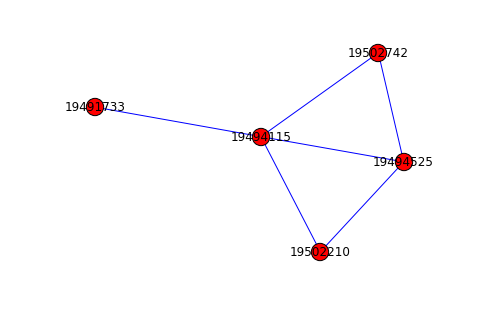

In [31]:
nx.draw(subs[0], with_labels=True, node_size=300, edge_color='b')

In [60]:
for sub in subs:
    cand = connected_observations(cat_in, sub)
    if len(cand._points)>3:
        orbit = Orbit(cand)
        print cand.writes()
        print orbit.ndof, orbit.chisq, orbit.elements, orbit.elements_errs
        print

2014/11/12 00:54:13,2:20:14.53,-4:22:12.8,376648,150.0,r,None,20.79809952,20916045
2014/11/12 00:57:11,2:20:14.44,-4:22:13.4,376649,200.0,i,None,20.64769936,20920321
2014/11/26 01:25:33,2:19:01.58,-4:25:38.3,381516,150.0,r,None,22.83930016,20930709
2014/12/23 01:06:56,2:17:05.23,-4:27:06.7,390477,200.0,i,None,21.91589928,20963856

3 21.8515271963 {'a': 76.05631634191828, 'lan': 344.7345378759577, 'e': 0.40421008826727134, 'i': 157.2805607151232, 'top': 2468975.508214281, 'aop': 354.288581412637} {'a': 11.251327966624698, 'lan': 0.23680916957508341, 'e': 0.18136216966316798, 'i': 0.078053202134202984, 'top': 7327.9007171709991, 'aop': 35.13845873210127}

2014/10/30 04:48:35,2:19:33.08,-5:14:37.0,372936,150.0,r,None,21.49150085,20880847
2014/11/19 01:18:22,2:17:56.16,-5:23:44.7,379277,150.0,r,None,23.20350075,20930563
2014/11/26 01:25:33,2:17:24.35,-5:26:03.2,381516,150.0,r,None,22.7602005,20933019
2014/11/26 01:28:32,2:17:24.27,-5:26:03.1,381517,200.0,i,None,22.93700027,20937439

3 15.0